# Model Evaluation

<br><hr>

[![image.png](https://i.postimg.cc/y8G0BJTg/image.png)](https://postimg.cc/MnynmpNq)



```
where
A: Positive
B: Negative
```

<hr>

Source: [Google ML Crash Course](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)

```
where:
    - TP: True Positive
    - FP: False Positive
    - TN: True Negative
    - FN: False Negative
```


<br>

#### Recall or Sensitivity (True Positive rate)

$$
Recall = \frac{TP}{(TP + FN)} = \frac{TP}{Actual_{Positives}}
$$


####  False Positive rate

$$
FPR = \frac{FP}{(FP + TN)}
$$

#### Precision

$$
Precision = \frac{TP}{(TP + FP)}
$$


#### F1 Score

$$
F1_{score} = \frac{(2 * Precision* Recall)}{(Precision + Recall)}
$$


#### Specificity (True Negative Rate)

$$
Specificity = \frac{TN}{(TN + FP)}
$$

#### Accuracy

$$
Accuracy = \frac{(TP + TN)}{(TN + FP + FN + TP)}
$$


<br><br><hr>

<hr>

In [1]:
# Built-in library
import copy
import logging
from typing import Any, Optional, Sequence, Union

# Standard imports
import numpy as np
import numpy.typing as npt
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Configure the backend
import matplotlib_inline.backend_inline

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 2_000

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
import seaborn as sns

# Custom import
from src.utilities import (
    set_up_logger,
    create_iris_data,
    create_qwerties_data,
    smooth,
)
from src.data_manager import (
    load_data,
    create_data_loader,
    split_into_train_n_validation,
)
from src.preprocessor import Standardizer, Normalizer


# Black code formatter (Optional)
%load_ext lab_black
# auto reload imports
%load_ext autoreload
%autoreload 2

### Load Wine Data

In [2]:
fp = "../../data/wine_data.csv"
wine_data = load_data(filename=fp)

wine_data.head()

Shape of data: (1599, 12)



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
X = wine_data.iloc[:, :-1]

X.shape

(1599, 11)

In [4]:
# Select all the features bar the target.
X = wine_data.iloc[:, :-1]

# Normalize the data
norm_ = Normalizer(min_value=0, max_value=1)
X_norm = norm_.fit_transform(X=X)

X_norm.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.247788,0.397260,0.00,0.068493,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846
1,0.283186,0.520548,0.00,0.116438,0.143573,0.338028,0.215548,0.494126,0.362205,0.209581,0.215385
2,0.283186,0.438356,0.04,0.095890,0.133556,0.197183,0.169611,0.508811,0.409449,0.191617,0.215385
3,0.584071,0.109589,0.56,0.068493,0.105175,0.225352,0.190813,0.582232,0.330709,0.149701,0.215385
4,0.247788,0.397260,0.00,0.068493,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846


In [5]:
# Binarize output
choice_list = [0, 1]

# 3, 4, and 5 : 0, else 1
wine_data["target"] = np.where(
    wine_data["quality"].isin(np.arange(3, 6)), choice_list[0], choice_list[1]
)

wine_data[["quality", "target"]].sample(5, random_state=5)

,quality,target
236,6,1
833,4,0
424,5,0
982,6,1
1155,5,0


In [6]:
# Convert to Tensors
X = torch.Tensor(X_norm.to_numpy())

# Requred by PyTorch to be 2D instead of 1D
y = torch.Tensor(wine_data["target"].to_numpy()).reshape(-1, 1)

# Split data
TEST_SIZE, RANDOM_STATE = 0.2, 123

X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

X_train.shape, X_validation.shape

(torch.Size([1279, 11]), torch.Size([320, 11]))

In [7]:
BATCH_SIZE, SHUFFLE = 32, True
DROP_LAST = True


# Create PyTorch datasets and dataloader objects.
train_data = TensorDataset(X_train, y_train)
validation_data = TensorDataset(X_validation, y_validation)

train_DL = DataLoader(
    dataset=train_data, batch_size=BATCH_SIZE, shuffle=SHUFFLE, drop_last=DROP_LAST
)
validation_DL = DataLoader(
    dataset=validation_data,
    batch_size=validation_data.tensors[0].shape[0],
)

In [8]:
# Build Model
class Net(nn.Module):
    """This is used to build a Feed Forward Network architecture that
    is used for classification."""

    def __init__(self) -> None:
        super().__init__()
        self.input = nn.Linear(11, 32)
        self.hidden_1 = nn.Linear(32, 32)
        self.hidden_2 = nn.Linear(32, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """This is used to implement forward prop."""
        X = F.relu(self.input(X))
        X = F.relu(self.hidden_1(X))
        X = F.relu(self.hidden_2(X))
        X = torch.sigmoid(self.output(X))
        return X


def train_model(
    *,
    train_dataloader: DataLoader,
    validation_dataloader: DataLoader,
    epochs: int,
    learning_rate: float,
    optimizer_name: str,
):
    """This is used to train the FFN model."""
    net, PCT = Net(), 100
    THRESH, __optimizer__ = 0.5, getattr(torch.optim, optimizer_name)
    optimizer = __optimizer__(params=net.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()
    train_loss = torch.zeros(size=(epochs,))
    train_accuracy, validation_accuracy = (
        np.zeros(shape=(epochs,)),
        np.zeros(shape=(epochs,)),
    )

    print(f"Training epoch:")
    for epoch_idx in np.arange(epochs):
        net.train()
        batch_accuracy, batch_loss = [], []

        for X_, y_ in train_dataloader:
            # Reset gradients
            optimizer.zero_grad()

            # Forward prop and loss
            y_proba = net(X_)
            loss = criterion(y_proba, y_)

            y_pred = (y_proba > THRESH).float()
            acc = torch.mean((y_ == y_pred).float()) * PCT
            batch_accuracy.append(acc.detach())

            batch_loss.append(loss.detach())

            # Backprop
            loss.backward()
            optimizer.step()

        # Train Metrics
        train_accuracy[epoch_idx] = np.mean(batch_accuracy)
        train_loss[epoch_idx] = np.mean(batch_loss, dtype="float64")

        # Validation Metrics
        net.eval()

        X_val, y_val = next(iter(validation_dataloader))
        y_proba_val = net(X_val)
        y_pred_val = (y_proba_val > THRESH).float()
        acc_ = torch.mean((y_pred_val == y_val).float()) * PCT
        validation_accuracy[epoch_idx] = acc_
        if epoch_idx % 250 == 0:
            print(f"{epoch_idx} ", end="")

    return (train_accuracy, validation_accuracy, train_loss, net)

In [9]:
EPOCHS, LEARNING_RATE = 1_000, 0.01
OPTIMIZER_NAME = "SGD"

train_accuracy, validation_accuracy, train_loss, trained_net = train_model(
    train_dataloader=train_DL,
    validation_dataloader=validation_DL,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    optimizer_name=OPTIMIZER_NAME,
)

Training epoch:
0 250 500 750 

In [10]:
THRESH = 0.5
# Get metrics for training data
train_pred = trained_net(train_DL.dataset.tensors[0])
train_pred = (train_pred > THRESH).float()
train_pred

tensor([[1.],
        [0.],
        [0.],
        ...,
        [1.],
        [0.],
        [1.]])

In [11]:
# Get metrics for validation data
validation_pred = trained_net(validation_DL.dataset.tensors[0]).detach()
validation_pred = (validation_pred > THRESH).float()
validation_pred[:3]

tensor([[1.],
        [0.],
        [0.]])

In [12]:
from sklearn import metrics


train_metrics, validation_metrics = np.zeros(shape=(1, 4)), np.zeros(shape=(1, 4))

# Train metrics
train_metrics[:, 0] = metrics.accuracy_score(y_true=y_train, y_pred=train_pred)
train_metrics[:, 1] = metrics.precision_score(y_true=y_train, y_pred=train_pred)
train_metrics[:, 2] = metrics.recall_score(y_true=y_train, y_pred=train_pred)
train_metrics[:, 3] = metrics.f1_score(y_true=y_train, y_pred=train_pred)

# Validation metrics
validation_metrics[:, 0] = metrics.accuracy_score(
    y_true=y_validation, y_pred=validation_pred
)
validation_metrics[:, 1] = metrics.precision_score(
    y_true=y_validation, y_pred=validation_pred
)
validation_metrics[:, 2] = metrics.recall_score(
    y_true=y_validation, y_pred=validation_pred
)
validation_metrics[:, 3] = metrics.f1_score(y_true=y_validation, y_pred=validation_pred)

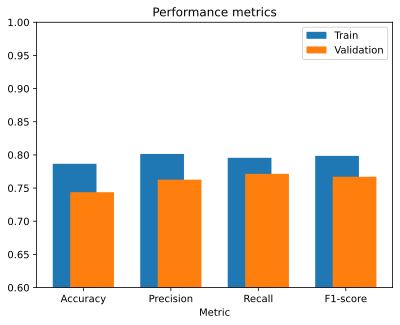

In [13]:
# Visualize metrics
plt.bar(np.arange(4) - 0.1, train_metrics.flatten(), 0.5, label="Train")
plt.bar(np.arange(4) + 0.1, validation_metrics.flatten(), 0.5, label="Validation")
plt.xlabel("Metric")
plt.xticks([0, 1, 2, 3], ["Accuracy", "Precision", "Recall", "F1-score"])
plt.ylim([0.6, 1])
plt.legend(loc="best")
plt.title("Performance metrics")
plt.show()

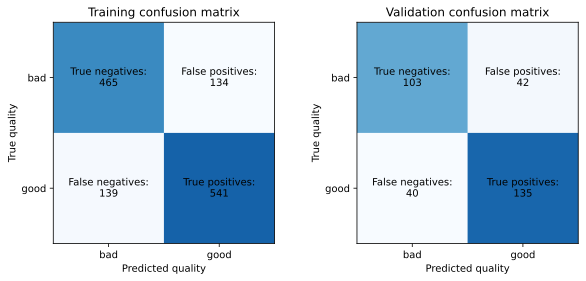

In [14]:
# Confusion matrices
train_conf_matr = metrics.confusion_matrix(train_DL.dataset.tensors[1], train_pred > 0)
validation_conf_matr = metrics.confusion_matrix(
    validation_DL.dataset.tensors[1], validation_pred > 0
)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Confusion Matrix during Training
ax[0].imshow(train_conf_matr, "Blues", vmax=len(train_pred) / 2)
ax[0].set_xticks([0, 1])
ax[0].set_yticks([0, 1])
ax[0].set_xticklabels(["bad", "good"])
ax[0].set_yticklabels(["bad", "good"])
ax[0].set_xlabel("Predicted quality")
ax[0].set_ylabel("True quality")
ax[0].set_title("Training confusion matrix")

# add text labels
ax[0].text(0, 0, f"True negatives:\n{train_conf_matr[0,0]}", ha="center", va="center")
ax[0].text(0, 1, f"False negatives:\n{train_conf_matr[1,0]}", ha="center", va="center")
ax[0].text(1, 1, f"True positives:\n{train_conf_matr[1,1]}", ha="center", va="center")
ax[0].text(1, 0, f"False positives:\n{train_conf_matr[0,1]}", ha="center", va="center")


# Confusion Matrix during Validation
ax[1].imshow(validation_conf_matr, "Blues", vmax=len(validation_pred) / 2)
ax[1].set_xticks([0, 1])
ax[1].set_yticks([0, 1])
ax[1].set_xticklabels(["bad", "good"])
ax[1].set_yticklabels(["bad", "good"])
ax[1].set_xlabel("Predicted quality")
ax[1].set_ylabel("True quality")
ax[1].set_title("Validation confusion matrix")

# add text labels
ax[1].text(
    0, 0, f"True negatives:\n{validation_conf_matr[0,0]}", ha="center", va="center"
)
ax[1].text(
    0, 1, f"False negatives:\n{validation_conf_matr[1,0]}", ha="center", va="center"
)
ax[1].text(
    1, 1, f"True positives:\n{validation_conf_matr[1,1]}", ha="center", va="center"
)
ax[1].text(
    1, 0, f"False positives:\n{validation_conf_matr[0,1]}", ha="center", va="center"
)
plt.show()

## Evaluate The Performance Metrics Of A Multi-class Labels

In [15]:
fp = "../../data/mnist_digit/mnist_train.csv"
mnist_data = load_data(filename=fp)

mnist_data.head()

Shape of data: (60000, 785)



,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,1x11,1x12,1x13,1x14,1x15,1x16,1x17,1x18,1x19,1x20,1x21,1x22,1x23,1x24,1x25,1x26,1x27,1x28,2x1,2x2,2x3,2x4,2x5,2x6,2x7,2x8,2x9,2x10,2x11,2x12,2x13,2x14,2x15,2x16,2x17,2x18,2x19,2x20,2x21,2x22,2x23,2x24,2x25,2x26,2x27,2x28,3x1,3x2,3x3,3x4,3x5,3x6,3x7,3x8,3x9,3x10,3x11,3x12,3x13,3x14,3x15,3x16,3x17,3x18,3x19,3x20,3x21,3x22,3x23,3x24,3x25,3x26,3x27,3x28,4x1,4x2,4x3,4x4,4x5,4x6,4x7,4x8,4x9,4x10,4x11,4x12,4x13,4x14,4x15,4x16,4x17,4x18,4x19,4x20,4x21,4x22,4x23,4x24,4x25,4x26,4x27,4x28,5x1,5x2,5x3,5x4,5x5,5x6,5x7,5x8,5x9,5x10,5x11,5x12,5x13,5x14,5x15,5x16,5x17,5x18,5x19,5x20,5x21,5x22,5x23,5x24,5x25,5x26,5x27,5x28,6x1,6x2,6x3,6x4,6x5,6x6,6x7,6x8,6x9,6x10,6x11,6x12,6x13,6x14,6x15,6x16,6x17,6x18,6x19,6x20,6x21,6x22,6x23,6x24,6x25,6x26,6x27,6x28,7x1,7x2,7x3,7x4,7x5,7x6,7x7,7x8,7x9,7x10,7x11,7x12,7x13,7x14,7x15,7x16,7x17,7x18,7x19,7x20,7x21,7x22,7x23,7x24,7x25,7x26,7x27,7x28,8x1,8x2,8x3,8x4,8x5,8x6,8x7,8x8,8x9,8x10,8x11,8x12,8x13,8x14,8x15,8x16,8x17,8x18,8x19,8x20,8x21,8x22,8x23,8x24,8x25,8x26,8x27,8x28,9x1,9x2,9x3,9x4,9x5,9x6,9x7,9x8,9x9,9x10,9x11,9x12,9x13,9x14,9x15,9x16,9x17,9x18,9x19,9x20,9x21,9x22,9x23,9x24,9x25,9x26,9x27,9x28,10x1,10x2,10x3,10x4,10x5,10x6,10x7,10x8,10x9,10x10,10x11,10x12,10x13,10x14,10x15,10x16,10x17,10x18,10x19,10x20,10x21,10x22,10x23,10x24,10x25,10x26,10x27,10x28,11x1,11x2,11x3,11x4,11x5,11x6,11x7,11x8,11x9,11x10,11x11,11x12,11x13,11x14,11x15,11x16,11x17,11x18,11x19,11x20,11x21,11x22,11x23,11x24,11x25,11x26,11x27,11x28,12x1,12x2,12x3,12x4,12x5,12x6,12x7,12x8,12x9,12x10,12x11,12x12,12x13,12x14,12x15,12x16,12x17,12x18,12x19,12x20,12x21,12x22,12x23,12x24,12x25,12x26,12x27,12x28,13x1,13x2,13x3,13x4,13x5,13x6,13x7,13x8,13x9,13x10,13x11,13x12,13x13,13x14,13x15,13x16,13x17,13x18,13x19,13x20,13x21,13x22,13x23,13x24,13x25,13x26,13x27,13x28,14x1,14x2,14x3,14x4,14x5,14x6,14x7,14x8,14x9,14x10,14x11,14x12,14x13,14x14,14x15,14x16,14x17,14x18,14x19,14x20,14x21,14x22,14x23,14x24,14x25,14x26,14x27,14x28,15x1,15x2,15x3,15x4,15x5,15x6,15x7,15x8,15x9,15x10,15x11,15x12,15x13,15x14,15x15,15x16,15x17,15x18,15x19,15x20,15x21,15x22,15x23,15x24,15x25,15x26,15x27,15x28,16x1,16x2,16x3,16x4,16x5,16x6,16x7,16x8,16x9,16x10,16x11,16x12,16x13,16x14,16x15,16x16,16x17,16x18,16x19,16x20,16x21,16x22,16x23,16x24,16x25,16x26,16x27,16x28,17x1,17x2,17x3,17x4,17x5,17x6,17x7,17x8,17x9,17x10,17x11,17x12,17x13,17x14,17x15,17x16,17x17,17x18,17x19,17x20,17x21,17x22,17x23,17x24,17x25,17x26,17x27,17x28,18x1,18x2,18x3,18x4,18x5,18x6,18x7,18x8,18x9,18x10,18x11,18x12,18x13,18x14,18x15,18x16,18x17,18x18,18x19,18x20,18x21,18x22,18x23,18x24,18x25,18x26,18x27,18x28,19x1,19x2,19x3,19x4,19x5,19x6,19x7,19x8,19x9,19x10,19x11,19x12,19x13,19x14,19x15,19x16,19x17,19x18,19x19,19x20,19x21,19x22,19x23,19x24,19x25,19x26,19x27,19x28,20x1,20x2,20x3,20x4,20x5,20x6,20x7,20x8,20x9,20x10,20x11,20x12,20x13,20x14,20x15,20x16,20x17,20x18,20x19,20x20,20x21,20x22,20x23,20x24,20x25,20x26,20x27,20x28,21x1,21x2,21x3,21x4,21x5,21x6,21x7,21x8,21x9,21x10,21x11,21x12,21x13,21x14,21x15,21x16,21x17,21x18,21x19,21x20,21x21,21x22,21x23,21x24,21x25,21x26,21x27,21x28,22x1,22x2,22x3,22x4,22x5,22x6,22x7,22x8,22x9,22x10,22x11,22x12,22x13,22x14,22x15,22x16,22x17,22x18,22x19,22x20,22x21,22x22,22x23,22x24,22x25,22x26,22x27,22x28,23x1,23x2,23x3,23x4,23x5,23x6,23x7,23x8,23x9,23x10,23x11,23x12,23x13,23x14,23x15,23x16,23x17,23x18,23x19,23x20,23x21,23x22,23x23,23x24,23x25,23x26,23x27,23x28,24x1,24x2,24x3,24x4,24x5,24x6,24x7,24x8,24x9,24x10,24x11,24x12,24x13,24x14,24x15,24x16,24x17,24x18,24x19,24x20,24x21,24x22,24x23,24x24,24x25,24x26,24x27,24x28,25x1,25x2,25x3,25x4,25x5,25x6,25x7,25x8,25x9,25x10,25x11,25x12,25x13,25x14,25x15,25x16,25x17,25x18,25x19,25x20,25x21,25x22,25x23,25x24,25x25,25x26,25x27,25x28,26x1,26x2,26x3,26x4,26x5,26x6,26x7,26x8,26x9,26x10,26x11,26x12,26x13,26x14,26x15,26x16,26x17,26x18,26x19,26x20,26x21,26x22,26x23,26x24,26x25,26x26,26x27,26x28,27x1,27x2,27x3,27x4,27x5,27x6,27x7,27x8,27x9,27x10,27x11,27x12,27x13,27x14,27x15,27x16,27x17,27x18,27x19,27x20,

In [16]:
X = mnist_data.iloc[:, 1:]
y = mnist_data.iloc[:, 0]

X.shape, y.shape, y.unique()

((60000, 784), (60000,), array([5, 0, 4, 1, 9, 2, 3, 6, 7, 8]))

In [17]:
# Normalize data
X_norm = X / np.max(X)  # Since np.min(X) = 0

X_norm.describe()

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,1x11,1x12,1x13,1x14,1x15,1x16,1x17,1x18,1x19,1x20,1x21,1x22,1x23,1x24,1x25,1x26,1x27,1x28,2x1,2x2,2x3,2x4,2x5,2x6,2x7,2x8,2x9,2x10,2x11,2x12,2x13,2x14,2x15,2x16,2x17,2x18,2x19,2x20,2x21,2x22,2x23,2x24,2x25,2x26,2x27,2x28,3x1,3x2,3x3,3x4,3x5,3x6,3x7,3x8,3x9,3x10,3x11,3x12,3x13,3x14,3x15,3x16,3x17,3x18,3x19,3x20,3x21,3x22,3x23,3x24,3x25,3x26,3x27,3x28,4x1,4x2,4x3,4x4,4x5,4x6,4x7,4x8,4x9,4x10,4x11,4x12,4x13,4x14,4x15,4x16,4x17,4x18,4x19,4x20,4x21,4x22,4x23,4x24,4x25,4x26,4x27,4x28,5x1,5x2,5x3,5x4,5x5,5x6,5x7,5x8,5x9,5x10,5x11,5x12,5x13,5x14,5x15,5x16,5x17,5x18,5x19,5x20,5x21,5x22,5x23,5x24,5x25,5x26,5x27,5x28,6x1,6x2,6x3,6x4,6x5,6x6,6x7,6x8,6x9,6x10,6x11,6x12,6x13,6x14,6x15,6x16,6x17,6x18,6x19,6x20,6x21,6x22,6x23,6x24,6x25,6x26,6x27,6x28,7x1,7x2,7x3,7x4,7x5,7x6,7x7,7x8,7x9,7x10,7x11,7x12,7x13,7x14,7x15,7x16,7x17,7x18,7x19,7x20,7x21,7x22,7x23,7x24,7x25,7x26,7x27,7x28,8x1,8x2,8x3,8x4,8x5,8x6,8x7,8x8,8x9,8x10,8x11,8x12,8x13,8x14,8x15,8x16,8x17,8x18,8x19,8x20,8x21,8x22,8x23,8x24,8x25,8x26,8x27,8x28,9x1,9x2,9x3,9x4,9x5,9x6,9x7,9x8,9x9,9x10,9x11,9x12,9x13,9x14,9x15,9x16,9x17,9x18,9x19,9x20,9x21,9x22,9x23,9x24,9x25,9x26,9x27,9x28,10x1,10x2,10x3,10x4,10x5,10x6,10x7,10x8,10x9,10x10,10x11,10x12,10x13,10x14,10x15,10x16,10x17,10x18,10x19,10x20,10x21,10x22,10x23,10x24,10x25,10x26,10x27,10x28,11x1,11x2,11x3,11x4,11x5,11x6,11x7,11x8,11x9,11x10,11x11,11x12,11x13,11x14,11x15,11x16,11x17,11x18,11x19,11x20,11x21,11x22,11x23,11x24,11x25,11x26,11x27,11x28,12x1,12x2,12x3,12x4,12x5,12x6,12x7,12x8,12x9,12x10,12x11,12x12,12x13,12x14,12x15,12x16,12x17,12x18,12x19,12x20,12x21,12x22,12x23,12x24,12x25,12x26,12x27,12x28,13x1,13x2,13x3,13x4,13x5,13x6,13x7,13x8,13x9,13x10,13x11,13x12,13x13,13x14,13x15,13x16,13x17,13x18,13x19,13x20,13x21,13x22,13x23,13x24,13x25,13x26,13x27,13x28,14x1,14x2,14x3,14x4,14x5,14x6,14x7,14x8,14x9,14x10,14x11,14x12,14x13,14x14,14x15,14x16,14x17,14x18,14x19,14x20,14x21,14x22,14x23,14x24,14x25,14x26,14x27,14x28,15x1,15x2,15x3,15x4,15x5,15x6,15x7,15x8,15x9,15x10,15x11,15x12,15x13,15x14,15x15,15x16,15x17,15x18,15x19,15x20,15x21,15x22,15x23,15x24,15x25,15x26,15x27,15x28,16x1,16x2,16x3,16x4,16x5,16x6,16x7,16x8,16x9,16x10,16x11,16x12,16x13,16x14,16x15,16x16,16x17,16x18,16x19,16x20,16x21,16x22,16x23,16x24,16x25,16x26,16x27,16x28,17x1,17x2,17x3,17x4,17x5,17x6,17x7,17x8,17x9,17x10,17x11,17x12,17x13,17x14,17x15,17x16,17x17,17x18,17x19,17x20,17x21,17x22,17x23,17x24,17x25,17x26,17x27,17x28,18x1,18x2,18x3,18x4,18x5,18x6,18x7,18x8,18x9,18x10,18x11,18x12,18x13,18x14,18x15,18x16,18x17,18x18,18x19,18x20,18x21,18x22,18x23,18x24,18x25,18x26,18x27,18x28,19x1,19x2,19x3,19x4,19x5,19x6,19x7,19x8,19x9,19x10,19x11,19x12,19x13,19x14,19x15,19x16,19x17,19x18,19x19,19x20,19x21,19x22,19x23,19x24,19x25,19x26,19x27,19x28,20x1,20x2,20x3,20x4,20x5,20x6,20x7,20x8,20x9,20x10,20x11,20x12,20x13,20x14,20x15,20x16,20x17,20x18,20x19,20x20,20x21,20x22,20x23,20x24,20x25,20x26,20x27,20x28,21x1,21x2,21x3,21x4,21x5,21x6,21x7,21x8,21x9,21x10,21x11,21x12,21x13,21x14,21x15,21x16,21x17,21x18,21x19,21x20,21x21,21x22,21x23,21x24,21x25,21x26,21x27,21x28,22x1,22x2,22x3,22x4,22x5,22x6,22x7,22x8,22x9,22x10,22x11,22x12,22x13,22x14,22x15,22x16,22x17,22x18,22x19,22x20,22x21,22x22,22x23,22x24,22x25,22x26,22x27,22x28,23x1,23x2,23x3,23x4,23x5,23x6,23x7,23x8,23x9,23x10,23x11,23x12,23x13,23x14,23x15,23x16,23x17,23x18,23x19,23x20,23x21,23x22,23x23,23x24,23x25,23x26,23x27,23x28,24x1,24x2,24x3,24x4,24x5,24x6,24x7,24x8,24x9,24x10,24x11,24x12,24x13,24x14,24x15,24x16,24x17,24x18,24x19,24x20,24x21,24x22,24x23,24x24,24x25,24x26,24x27,24x28,25x1,25x2,25x3,25x4,25x5,25x6,25x7,25x8,25x9,25x10,25x11,25x12,25x13,25x14,25x15,25x16,25x17,25x18,25x19,25x20,25x21,25x22,25x23,25x24,25x25,25x26,25x27,25x28,26x1,26x2,26x3,26x4,26x5,26x6,26x7,26x8,26x9,26x10,26x11,26x12,26x13,26x14,26x15,26x16,26x17,26x18,26x19,26x20,26x21,26x22,26x23,26x24,26x25,26x26,26x27,26x28,27x1,27x2,27x3,27x4,27x5,27x6,27x7,27x8,27x9,27x10,27x11,27x12,27x13,27x14,27x15,27x16,27x17,27x18,27x19,27x20,27x21,

In [18]:
BATCH_SIZE = 32

# Split data into train and validation sets
X_train, X_validation, y_train, y_validation = split_into_train_n_validation(
    data=X_norm, labels=y, convert_to_long=True
)

# Dataloader objects
train_DL, validation_DL = create_data_loader(
    X_train=X_train,
    X_validation=X_validation,
    y_train=y_train,
    y_validation=y_validation,
    batch_size=BATCH_SIZE,
)

[INFO]:: 2023-06-03 16:23:54,354:: X_train: torch.Size([48000, 784])
X_validation: torch.Size([12000, 784])



In [19]:
# Build Model
class Net(nn.Module):
    """This is used to build a Feed Forward Network architecture that
    is used for classification."""

    def __init__(self) -> None:
        super().__init__()
        self.input = nn.Linear(784, 32)
        self.hidden = nn.Linear(32, 32)
        self.output = nn.Linear(32, 10)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """This is used to implement forward prop."""
        X = F.relu(self.input(X))
        X = F.relu(self.hidden(X))
        X = torch.log_softmax(self.output(X), dim=1)
        return X


def train_model(
    *,
    train_dataloader: DataLoader,
    validation_dataloader: DataLoader,
    epochs: int,
    learning_rate: float,
    optimizer_name: str,
):
    """This is used to train the FFN model."""
    net, PCT = Net(), 100
    __optimizer__ = getattr(torch.optim, optimizer_name)
    optimizer = __optimizer__(params=net.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    train_loss = torch.zeros(size=(epochs,))
    train_accuracy, validation_accuracy = (
        np.zeros(shape=(epochs,)),
        np.zeros(shape=(epochs,)),
    )

    print(f"Training epoch:")
    for epoch_idx in np.arange(epochs):
        net.train()
        batch_accuracy, batch_loss = [], []

        for X_, y_ in train_dataloader:
            # Reset gradients
            optimizer.zero_grad()

            # Forward prop and loss
            y_proba = net(X_)
            loss = criterion(y_proba, y_)

            y_pred = torch.argmax(y_proba, dim=1)
            acc = torch.mean((y_pred == y_).float()) * PCT
            batch_accuracy.append(acc.detach())

            batch_loss.append(loss.detach())

            # Backprop
            loss.backward()
            optimizer.step()

        # Train Metrics
        train_accuracy[epoch_idx] = np.mean(batch_accuracy)
        train_loss[epoch_idx] = np.mean(batch_loss, dtype="float64")

        # Validation Metrics
        net.eval()

        X_val, y_val = next(iter(validation_dataloader))
        y_proba_val = net(X_val)
        y_pred_val = torch.argmax(y_proba_val, dim=1)
        acc_ = torch.mean((y_pred_val == y_val).float()) * PCT
        validation_accuracy[epoch_idx] = acc_
        if epoch_idx % 25 == 0:
            print(f"{epoch_idx} ", end="")

    return (train_accuracy, validation_accuracy, train_loss, net)

In [20]:
EPOCHS, LEARNING_RATE = 50, 0.01
OPTIMIZER_NAME = "SGD"

train_accuracy, validation_accuracy, train_loss, trained_net = train_model(
    train_dataloader=train_DL,
    validation_dataloader=validation_DL,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    optimizer_name=OPTIMIZER_NAME,
)

Training epoch:
0 25 

In [21]:
# Get metrics for training data
train_proba = trained_net(train_DL.dataset.tensors[0])
train_pred = torch.argmax(train_proba, dim=1)
train_pred

tensor([3, 2, 0,  ..., 0, 9, 4])

In [22]:
# Get metrics for validation data
validation_proba = trained_net(validation_DL.dataset.tensors[0])
validation_pred = torch.argmax(validation_proba, dim=1)
validation_pred[:3]

tensor([4, 3, 8])

In [23]:
train_metrics, validation_metrics = np.zeros(shape=(1, 4)), np.zeros(shape=(1, 4))

# Train metrics
train_metrics[:, 0] = metrics.accuracy_score(y_true=y_train, y_pred=train_pred)
train_metrics[:, 1] = metrics.precision_score(
    y_true=y_train, y_pred=train_pred, average="weighted"
)
train_metrics[:, 2] = metrics.recall_score(
    y_true=y_train, y_pred=train_pred, average="weighted"
)
train_metrics[:, 3] = metrics.f1_score(
    y_true=y_train, y_pred=train_pred, average="weighted"
)

# Validation metrics
validation_metrics[:, 0] = metrics.accuracy_score(
    y_true=y_validation, y_pred=validation_pred
)
validation_metrics[:, 1] = metrics.precision_score(
    y_true=y_validation, y_pred=validation_pred, average="weighted"
)
validation_metrics[:, 2] = metrics.recall_score(
    y_true=y_validation, y_pred=validation_pred, average="weighted"
)
validation_metrics[:, 3] = metrics.f1_score(
    y_true=y_validation, y_pred=validation_pred, average="weighted"
)

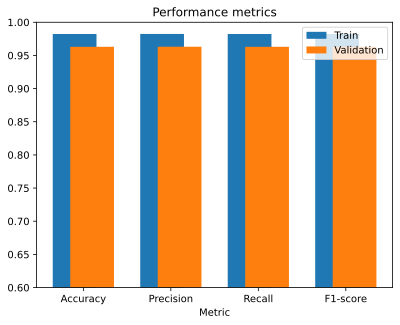

In [24]:
# Visualize metrics
plt.bar(np.arange(4) - 0.1, train_metrics.flatten(), 0.5, label="Train")
plt.bar(np.arange(4) + 0.1, validation_metrics.flatten(), 0.5, label="Validation")
plt.xlabel("Metric")
plt.xticks([0, 1, 2, 3], ["Accuracy", "Precision", "Recall", "F1-score"])
plt.ylim([0.6, 1])
plt.legend(loc="best")
plt.title("Performance metrics")
plt.show()

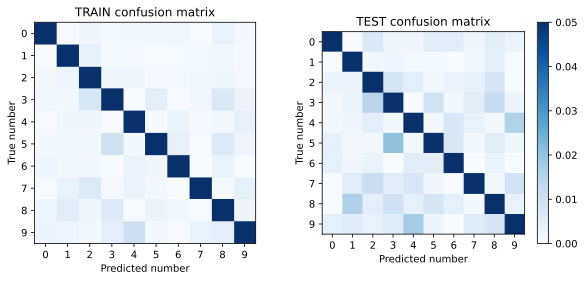

In [25]:
# Confusion matrices
train_conf_matr = metrics.confusion_matrix(
    train_DL.dataset.tensors[1], train_pred, normalize="true"
)
validation_conf_matr = metrics.confusion_matrix(
    validation_DL.dataset.tensors[1], validation_pred, normalize="true"
)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Confusion Matrix during Training
ax[0].imshow(train_conf_matr, "Blues", vmax=0.05)
ax[0].set_xticks(range(10))
ax[0].set_yticks(range(10))
ax[0].set_title("TRAIN confusion matrix")
ax[0].set_xlabel("True number")
ax[0].set_xlabel("Predicted number")
ax[0].set_ylabel("True number")

# Confusion Matrix during Validation
a = ax[1].imshow(validation_conf_matr, cmap="Blues", vmax=0.05)
ax[1].set_xticks(range(10))
ax[1].set_yticks(range(10))
ax[1].set_title("TEST confusion matrix")
ax[1].set_xlabel("Predicted number")
ax[1].set_ylabel("True number")

fig.colorbar(a)
plt.show()